# Alzheimer's Disease classification from anatomical MRI

### This notebook explores the use of a low-dimensional feature space to classify Alzheimer's disease from anatomical MRI images.

Briefly, the pipeline involves the following steps and technical features:

- Data formating and quality check
- Feature extraction and visualization
- Custom CNN for classification
- Transfer learning using ResNet50 

### Import analysis and plotting libraries

In [1]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
import pyspark
from pyspark.sql import SparkSession
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.stats import false_discovery_control

# Parallel computing
import dask
from dask.distributed import Client, progress

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2
import magic
from IPython.display import clear_output

In [ ]:
# import pyspark module
# spark = SparkSession.builder.appName("Brad's PySpark").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

### Load and format training data

In [2]:
BASE_DIR = "C:/Users/bedelman/Documents\GitHub/Alzheimers-MRI-Classification/Alzheimer_MRI_Dataset/Data/"

'''
Label meanings
0 - Mild dementia
1 - Moderate dementia
2 - No dementia
3 - Very mild dementia
'''
Lab = ['Mild', 'Moderate', 'None', 'Very Mild']

train = pd.read_parquet(f"{BASE_DIR}/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


#### Convert data to readable format

In [3]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

train['img_arr'] = train['image'].apply(dict_to_image)
train.drop("image", axis=1, inplace=True)
train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Load and format test data

In [4]:
test = pd.read_parquet(f"{BASE_DIR}/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
test.head() 

# Also convert to readable format
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)
test.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Explore structure and visualization of the data

### Distribution of the datasets (are all classes represented equally?)

Text(0, 0.5, '# of images')

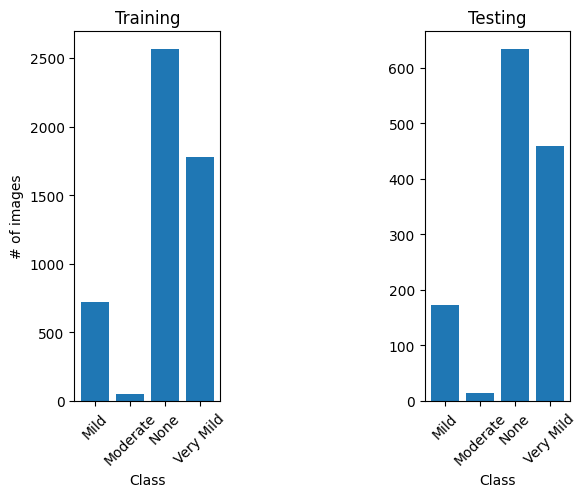

In [7]:
f, ax = plt.subplots(1,3)
unique, counts = np.unique(np.asarray(train.iloc[:].label), return_counts = True)
ax[0].bar(unique, counts)
ax[0].set_xticks(unique)
ax[0].set_xticklabels(Lab, rotation = 45)
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('# of images')

ax[1].axis('off')

unique, counts = np.unique(np.asarray(test.iloc[:].label), return_counts = True)
ax[2].bar(unique, counts)
ax[2].set_xticks(unique)
ax[2].set_xticklabels(Lab, rotation = 45)
ax[2].set_title('Testing')
ax[2].set_xlabel('Class')
ax[0].set_ylabel('# of images')

# An obvious imbalance across classes, but each class seems to be balanced across training/testing sets

## Visually inspect data

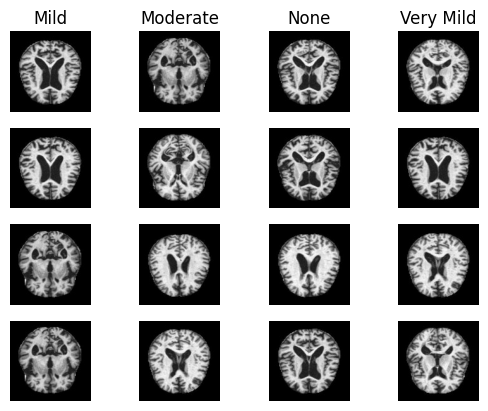

In [11]:
train_lab_idx = np.asarray(train.iloc[:].label)

f, ax = plt.subplots(4,4)
for lab in range(4):
    for ex in range(4):
    
        class_lab = np.argwhere(train_lab_idx == 1)
        current_idx = np.random.randint(len(class_lab)-1,size = 1)
        current_idx = np.asarray(current_idx)
        
        ax[ex, lab].axis('off')
        ax[ex, lab].imshow(train.iloc[class_lab[current_idx[0]][0]].img_arr, cmap = "gray")
        if ex == 0: ax[ex, lab].set_title(Lab[lab])

# Clearly, images show different slices within the brain, which may be a major confound...

## First, build a custom CNN for classification

## Next apply transfer learning using ResNet50